### Sales Forecast

**Motivation! What's the context?**
- In 2017 Olist started to forecast its monthly sales based on the average revenue from 3 months before. But now the company  wants to be able to predict future sales more accurately.

**Why?**
- To efficiently allocate resources for future projects, growth and manage its cash flow. 

**Who are the stakeholders?**
- The financial sector will use the forecast to the set operating budgets and to project cash flows.
- And the marketing team, who will have the opportunity to schedule promotions if it appears sales <br>
will be weak and will be able to better allocate budget among other marketing activities.

**What is the deliverable?**
- A dashboard with the information about the forecast.


> **ps: We will use the data to forecast the second quarter of 2018 and the third quarter will be our "production data".**

# Cycle Notes

**1st - Really Good Results! Overfitting? Probably.**

On average, our predictions are 0.8% above or below the real value. <br>
Which means an error of about R$ 7241.27

        freight_percentage_from_price with a importance of 72%. Let's remove it now.
        As well as freight_value, since we don't have this information at "prediction time".

**2nd - Bad Bad**

On average, our predictions are 36.66% above or below the real value.<br>
Which means an error of about R$ 330307.79

        I'll try to normalize the data instead of standardize

**3rd - Still Bad**

On average, our predictions are 36.96% above or below the real value.<br>
Which means an error of about R$ 332950.2

In [82]:
import os 
import pandas as pd
import numpy as np 

from sklearn.preprocessing import MinMaxScaler, LabelEncoder

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [38]:
# Settings
__file__ = "1.0-pr-sales-prediction-eda"
THIS_DIR = os.path.dirname(os.path.abspath(__file__))
BASE_DIR = os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))
DATA_DIR = os.path.join(os.path.join(BASE_DIR, 'data'))

In [83]:
def evaluation(y_true, y_pred, show_results=True):
    mae = mean_absolute_error(y_true, y_pred).round(2)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    if show_results:
        print(f'''On average, our predictions are {mape.round(2)}% above or below the real value.''')
        print(f'''Which means an error of about R$ {mae}''')
    return mae, mape

## Loading Data

In [375]:
data_frame_to_process = pd.read_pickle(os.path.join(os.path.join(DATA_DIR, "sales_forecast_data"), "ml_data_to_preprocess.pkl"))
df_evaluate = data_frame_to_process.copy()
# pd.DataFrame(df_evaluate.groupby([df_evaluate['order_purchase_timestamp'].dt.year, df_evaluate['order_purchase_timestamp'].dt.month]).price.sum())

In [376]:
mask = (data_frame_to_process['order_purchase_timestamp'] < '2018-4-1')
x_train = data_frame_to_process.loc[mask].drop(columns=['price'])

mask = (data_frame_to_process['order_purchase_timestamp'] >= '2018-4-1')
x_test = data_frame_to_process.loc[mask].drop(columns=['price'])

## 0.0 Filter Features

In [377]:
to_drop = ['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at',
           'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date',
           'customer_unique_id', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 
           'geolocation_zip_code_prefix', 'geolocation_city', 'geolocation_state',
           'freight_percentage_from_price', 'freight_value']
data_frame_to_process.drop(columns=to_drop, inplace=True)

## 1.0 Data Preparation/Transformation

In [378]:
data_frame = data_frame_to_process.copy()

### 1.1 Rescaling
 
**1.1.1. Min-Max Scaler**

In [379]:
columns = data_frame.select_dtypes(include=['int32', 'int64', 'float32', 'float64']).drop(columns=['price']).columns
min_max_scaler = MinMaxScaler()

for column in columns:
    min_max_scaler = MinMaxScaler()
    data_frame[column] = min_max_scaler.fit_transform(data_frame[[column]].values)

In [342]:
# from sklearn import preprocessing
# columns = data_frame.select_dtypes(include=['int64', 'float64']).drop(columns=['price']).columns
# for column in columns:
#     data_frame[column] = preprocessing.normalize([data_frame[column]])[0]

### 1.2 Feature Encoding

In [380]:
columns = data_frame.select_dtypes(exclude=['int32', 'int64', 'float32', 'float64', 'bool']).columns

for column in columns:
    label_encoder = LabelEncoder()
    data_frame[column] = label_encoder.fit_transform( data_frame[column] )

In [381]:
for column in columns:
    min_max_scaler = MinMaxScaler()
    data_frame[column] = min_max_scaler.fit_transform(data_frame[[column]].values)

### 1.3 Response Variable Transformation

In [382]:
data_frame['price'] =  np.log1p(data_frame['price'])

### 1.4 Nature Transformation (dates)

In [383]:
data_frame['purchase_timestamp_month_sin'] = data_frame['purchase_timestamp_month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
data_frame['purchase_timestamp_month_cos'] = data_frame['purchase_timestamp_month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

data_frame['estimated_delivery_date_month_sin'] = data_frame['estimated_delivery_date_month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
data_frame['estimated_delivery_date_month_cos'] = data_frame['estimated_delivery_date_month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

data_frame['purchase_timestamp_day_sin'] = data_frame['purchase_timestamp_day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
data_frame['purchase_timestamp_day_cos'] = data_frame['purchase_timestamp_day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )


data_frame['purchase_timestamp_weekofyear_sin'] = data_frame['purchase_timestamp_weekofyear'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
data_frame['purchase_timestamp_weekofyear_cos'] = data_frame['purchase_timestamp_weekofyear'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

data_frame['estimated_delivery_date_weekofyear_sin'] = data_frame['estimated_delivery_date_weekofyear'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
data_frame['estimated_delivery_date_weekofyear_cos'] = data_frame['estimated_delivery_date_weekofyear'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

In [384]:
data_frame.drop(columns=['purchase_timestamp_month','estimated_delivery_date_month','purchase_timestamp_day', 
                         'purchase_timestamp_weekofyear','estimated_delivery_date_weekofyear'], inplace=True)

## 2.0 Baseline Models

In [385]:
df = data_frame.copy()

### 2.1 raining Test Split

In [386]:
x_train = df.loc[x_train.index].drop(columns=['price'])
y_train = df.loc[x_train.index, 'price']

x_test = df.loc[x_test.index].drop(columns=['price'])
y_test = df.loc[x_test.index, 'price']

#### 2.1.2 RandomForestRegressor

Individual Prices

1st cycle:

    On average, our predictions are 2.29% above or below the real value.
    Which means an error of about R$ 3.76
    
2nd cycle

    On average, our predictions are 97.06% above or below the real value.
    Which means an error of about R$ 81.45
    
3rd cycle

    On average, our predictions are 96.64% above or below the real value.
    Which means an error of about R$ 81.5

In [387]:
rf = RandomForestRegressor(min_samples_leaf=9)
rf.fit(x_train, y_train)

rf_predictions = rf.predict(x_test)
evaluation(np.expm1(y_test), np.expm1(rf_predictions))

On average, our predictions are 96.7% above or below the real value.
Which means an error of about R$ 81.43


(81.43, 96.70030442108822)

<AxesSubplot:xlabel='month'>

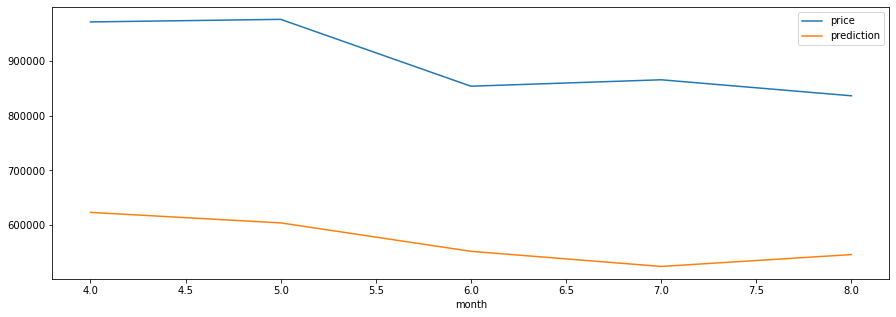

In [388]:
rf_evaluation = pd.concat([df_evaluate.loc[mask]['order_purchase_timestamp'],  np.expm1(y_test)], axis=1)
rf_evaluation = pd.concat([rf_evaluation.reset_index(drop=True), pd.Series(np.expm1(rf_predictions), name='prediction')], axis=1)
rf_evaluation['purchase_date'] = rf_evaluation['order_purchase_timestamp'].dt.date
rf_evaluation['month'] = a['order_purchase_timestamp'].dt.month
rf_evaluation.groupby('month').sum().plot(figsize=(15,5))

In [389]:
evaluation(rf_evaluation.groupby('month').sum()['price'], rf_evaluation.groupby('month').sum()['prediction'])

On average, our predictions are 36.69% above or below the real value.
Which means an error of about R$ 330682.75


(330682.75, 36.690436407113594)

#### 2.1.3 LinearRegression

Individual Prices

1st cycle:

    On average, our predictions are 57.94% above or below the real value.
    Which means an error of about R$ 308.92
    
2nd cycle

    On average, our predictions are 100.31% above or below the real value.
    Which means an error of about R$ 80.87
    
3rd cycle

    On average, our predictions are 100.36% above or below the real value.
    Which means an error of about R$ 80.88

In [353]:
lr = LinearRegression()
lr.fit(x_train, y_train)

lr_predictions = lr.predict(x_test)
evaluation(np.expm1(y_test), np.expm1(lr_predictions))

On average, our predictions are 100.36% above or below the real value.
Which means an error of about R$ 80.88


(80.88, 100.36170721979269)

<AxesSubplot:xlabel='month'>

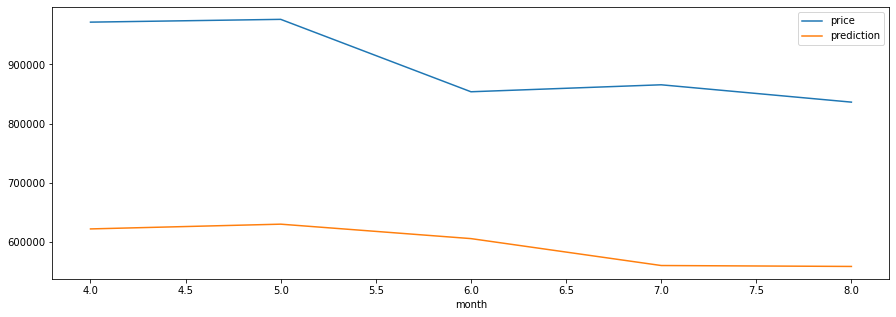

In [354]:
lr_evaluation = pd.concat([df_evaluate.loc[mask]['order_purchase_timestamp'], np.expm1(y_test)], axis=1)
lr_evaluation = pd.concat([lr_evaluation.reset_index(drop=True), pd.Series(np.expm1(lr_predictions), name='prediction')], axis=1)
lr_evaluation['purchase_date'] = lr_evaluation['order_purchase_timestamp'].dt.date
lr_evaluation['month'] = lr_evaluation['order_purchase_timestamp'].dt.month
lr_evaluation.groupby('month').sum().plot(figsize=(15,5))

In [355]:
evaluation(lr_evaluation.groupby('month').sum()['price'], lr_evaluation.groupby('month').sum()['prediction'])

On average, our predictions are 33.76% above or below the real value.
Which means an error of about R$ 305000.41


(305000.41, 33.76204904625188)

## 3.0 Features Importances

#### random forest importance

In [356]:
feature_importance = pd.concat([pd.Series(rf.feature_importances_, name='feature_importance'), pd.Series(x_train.columns, name='column')], axis=1)
feature_importance.round(2).sort_values('feature_importance', ascending=False)#.plot(kind='barh', x='column', figsize=(10,6));

,feature_importance,column
3,0.15,geolocation_lat
0,0.14,customer_zip_code_prefix
4,0.14,geolocation_lng
9,0.09,estimated_delivery_date_day
20,0.09,purchase_timestamp_day_sin
1,0.07,customer_city
13,0.06,purchase_timestamp_dayofweek
14,0.05,estimated_delivery_date_dayofweek
25,0.04,estimated_delivery_date_weekofyear_cos
23,0.04,purchase_timestamp_weekofyear_cos


##### Linear Regression Importance

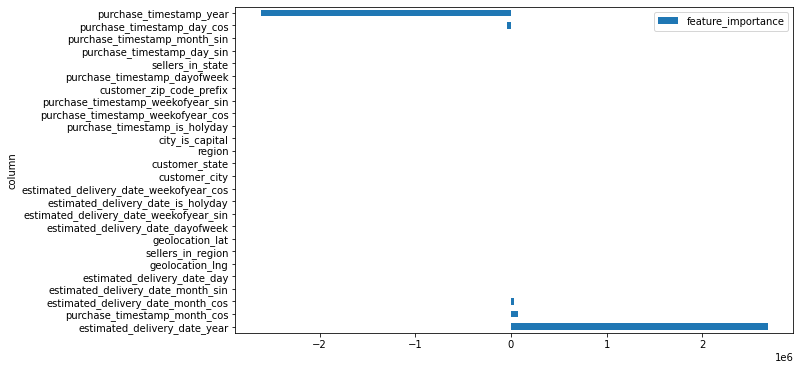

In [357]:
feature_importance = pd.concat([pd.Series(lr.coef_, name='feature_importance'), pd.Series(x_train.columns, name='column')], axis=1)
feature_importance.round(2).sort_values('feature_importance', ascending=False).plot(kind='barh', x='column', figsize=(10,6));